In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt

In [66]:
a = np.arange(100)
b = np.arange(50) + 75

In [73]:
a[25]

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
       93, 94, 95, 96, 97, 98, 99])

In [68]:
np.argmin(a < b[0])

75

In [81]:
np.argmin(b <= a[-1])

25

In [79]:
a[75:]

array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 98, 99])

In [80]:
b[:25]

array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
       92, 93, 94, 95, 96, 97, 98, 99])

In [232]:
def plot_loss_data(title, loss_data_path, draw_stop_epoch, draw_stop_step):
    loss_data = dict()
    epochs = []
    steps = []
    losses = []
    tokens = []
    
    fig, ax = plt.subplots()
    plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
    plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号
    
    
    # x, y: mindformer loss | x2, y2: torch loss
    x = []
    y = []
    x2 = []
    y2 = []

    for loss_file_name in os.listdir(loss_data_path):
        loss_file_pathname = os.path.join(loss_data_path, loss_file_name)
        if os.path.isdir(loss_file_pathname):
            continue

        label = loss_file_name.strip()[:-4]
        acc_50 = []
        device = None
        if loss_file_pathname.endswith(".log"):
            print(f"find ascend log file: {loss_file_pathname}")
            device = "ascend"
            x_temp = []
            y_temp = []
            filter_a = r"Epoch:\[(\s*\d+)/ (\d+)\], step:\[(\s*\d+)/(\d+)\], loss:\[(\d+\.\d+)/(\d+\.\d+)\], time:(\d+\.\d+) ms"
        elif loss_file_pathname.endswith(".out"):
            print(f"find torch log file: {loss_file_pathname}")
            device = "gpu"
#             data epoch: [4]  [  200/16204]  eta: 13:51:19  lr: 0.000085  loss: 5.0745  time: 2.9700
            filter_a = r"data epoch: \[(\s*\d+)\]  \[(\s*\d+)/(\d+)\]  eta: (.*)  lr: (\d+\.\d+)  loss: (\d+\.\d+)  time: (\d+\.\d+)"
        else:
            filter_a = r"================================="           
        for loss in re.finditer(filter_a, open(loss_file_pathname).read()):
            if device == "ascend":
                current_epoch = int(loss.groups()[0]) - 1
                total_epoch = int(loss.groups()[1])
                current_step = int(loss.groups()[2])
                if current_epoch > draw_stop_epoch: continue
                if current_epoch == draw_stop_epoch and current_step > draw_stop_step: continue
                total_step = int(loss.groups()[3])
                current_loss = round(float(loss.groups()[4]), 3)
                avg_loss = round(float(loss.groups()[5]), 3)
                time_step = round(float(loss.groups()[6]), 3)
#                 x_temp.append(current_step + current_epoch * total_step)
#                 y_temp.append(current_loss)
                acc_50.append(current_loss)
                if current_step % 50 == 0 or current_step == 1:
                    x_temp.append(current_step + current_epoch * total_step)
                    y_temp.append(np.array(acc_50).mean())
                    acc_50.clear()
            elif device == "gpu":
                current_epoch = int(loss.groups()[0])
                total_epoch = 15
                current_step = int(loss.groups()[1])
                if current_epoch > draw_stop_epoch: continue
                if current_epoch == draw_stop_epoch and current_step > draw_stop_step: continue
                total_step = int(loss.groups()[2])
                current_loss = round(float(loss.groups()[5]), 3)
                time_step = round(float(loss.groups()[6]), 3)
            
#                 print(f"current_epoch:{current_epoch}")
#                 print(f"total_epoch:{total_epoch}")
#                 print(f"current_step:{current_step}")
#                 print(f"total_step:{total_step}")
#                 print(f"current_loss:{current_loss}")
#                 print(f"avg_loss:{avg_loss}")
#                 print(f"time_step:{time_step}")
                x2.append(current_step + current_epoch * total_step)
                y2.append(current_loss)
        
        if device == "ascend":
            x_temp = np.array(x_temp)
            y_temp = np.array(y_temp)
            if loss_file_name == "modelarts-job-3c2ace1b-f898-43e5-807d-4ffd0170142b-worker-0.log":
                end = np.argmax(x_temp >= 2 * 16204)
                print("end: ", end)
                x_temp = x_temp[:end]
                y_temp = y_temp[:end]
            if len(x_temp) == 0: continue
            if len(x) == 0:
                x = [x_temp]
                y = [y_temp]
            else:
                for i in range(len(x)):
                    if x_temp[0] > x[i][0] and x_temp[-1] > x[i][-1]:
                        x.insert(i + 1, x_temp)
                        y.insert(i + 1, y_temp)
                        # average repeat points
                        if x_temp[0] <= x[i][-1]:
                            start = np.argmin(x[i] < x_temp[0])
                            end = np.argmin(x_temp <= x[i][-1])
                            x_temp[:end] = (x_temp[:end] + x[i][start:]) / 2
                            x[i] = x[i][:start]
                            y[i] = y[i][:start]
                    elif x_temp[0] >= x[i][0] and x_temp[-1] <= x[i][-1]:
                        print("enter branch 2")
                        start = np.argmin(x[i] < x_temp[0])
                        end = np.argmin(x[i] < x_temp[-1])
                        x[i][start:end] = (x[i][start:end] + x_temp) / 2
                    elif x_temp[0] < x[i][0] and x_temp[-1] > x[i][-1]:
                        print("enter branch 3")
                        start = np.argmin(x_temp < x[i][0])
                        end = np.argmin(x_temp < x[i][-1])
                        x_temp[start:end] = (x_temp[start:end] + x[i]) / 2
                        x[i] = x_temp
                    elif i == 0:
                        x.insert(0, x_temp)
                        y.insert(0, y_temp)
                        # average repeat points
                        
        losses.clear()
        tokens.clear()
        steps.clear()

    ax.plot(x2, y2, 'b', label='torch loss')
    x_final = []
    y_final = []
    for x_i in x:
        x_final += x_i.tolist()
    for y_i in y:
        y_final += y_i.tolist()
    ax.plot(x_final, y_final, 'r', label='mindformer loss')
    # 3rd epoch -  12982/13792
    ax.plot([45300, 45300], [3.5, 18.5], linestyle='--', color='purple', linewidth=1)
#     ax.plot([46200, 46200], [3.5, 18.5], linestyle='--', color='purple', linewidth=1)
    # 3rd epoch - 14392/16092
    ax.plot([46800, 46800], [3.5, 18.5], linestyle='--', color='orange', linewidth=1)
#     ax.plot([48500, 48500], [3.5, 18.5], linestyle='--', color='orange', linewidth=1)
        
    ax.set_xlabel('steps', fontsize=16)
    ax.set_ylabel('loss', fontsize=16)
    ax.legend(loc='best', fontsize=14)

    ax.set_title(title)
    ax.legend()
    plt.show()

find ascend log file: /mnt/c/Users/GeneYu/desktop/8-14/modelarts-job-28eb9914-0eb1-460d-a67b-2ea52bb1ef80-worker-0.log
find ascend log file: /mnt/c/Users/GeneYu/desktop/8-14/modelarts-job-3c2ace1b-f898-43e5-807d-4ffd0170142b-worker-0.log


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

end:  650
find torch log file: /mnt/c/Users/GeneYu/desktop/8-14/slurm-blip2-stage1.out


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

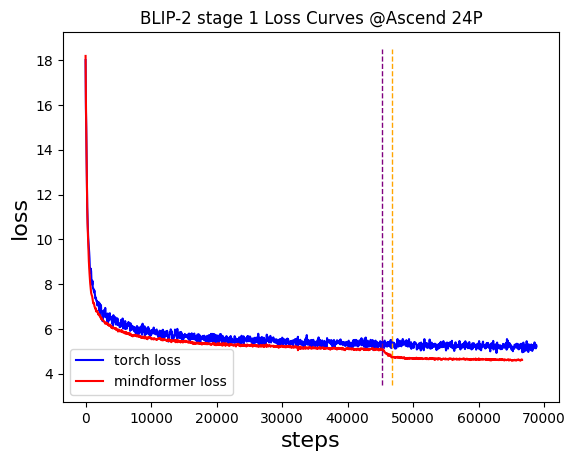

In [233]:
# if __name__ == "__main__":
loss_title = "BLIP-2 stage 1 Loss Curves @Ascend 24P"
loss_data_dir = "/mnt/c/Users/GeneYu/desktop/8-16"# sys.argv[-1]
plot_loss_data(loss_title, loss_data_dir, 4, 4000)

find ascend log file: /mnt/c/Users/GeneYu/desktop/8-15/modelarts-job-3c2ace1b-f898-43e5-807d-4ffd0170142b-worker-0.log
find ascend log file: /mnt/c/Users/GeneYu/desktop/8-15/modelarts-job-883a002f-280d-4ed2-8d9c-bb479e0f2473-worker-0.log


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

find torch log file: /mnt/c/Users/GeneYu/desktop/8-15/slurm-blip2-stage1.out


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

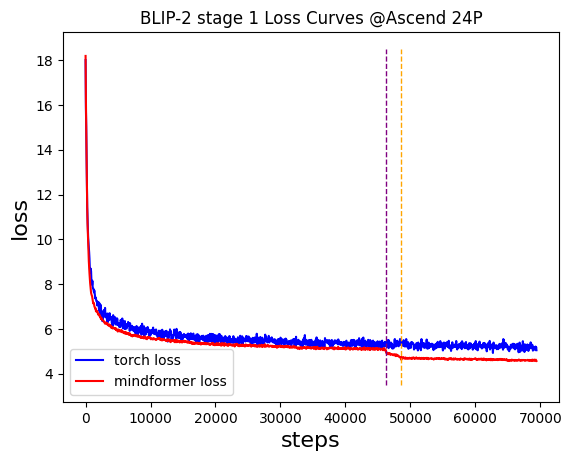

In [222]:
loss_title = "BLIP-2 stage 1 Loss Curves @Ascend 24P"
loss_data_dir = "/mnt/c/Users/GeneYu/desktop/8-15"# sys.argv[-1]
plot_loss_data(loss_title, loss_data_dir, 4, 4603)

find ascend log file: /mnt/c/Users/GeneYu/desktop/8-15/modelarts-job-3c2ace1b-f898-43e5-807d-4ffd0170142b-worker-0.log
find ascend log file: /mnt/c/Users/GeneYu/desktop/8-15/modelarts-job-883a002f-280d-4ed2-8d9c-bb479e0f2473-worker-0.log


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

find torch log file: /mnt/c/Users/GeneYu/desktop/8-15/slurm-blip2-stage1.out


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

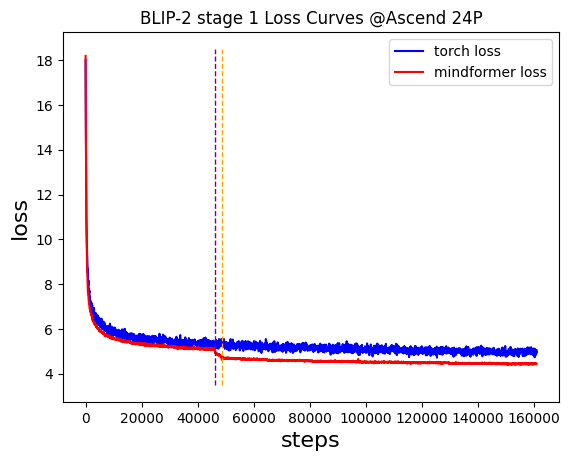

In [221]:
loss_title = "BLIP-2 stage 1 Loss Curves @Ascend 24P"
loss_data_dir = "/mnt/c/Users/GeneYu/desktop/8-15"# sys.argv[-1]
plot_loss_data(loss_title, loss_data_dir, 9, 15000)